 Publication case study
<font size="3">*By Joris Baars, Newcastle University, UK, 2022* (joris.baars@hotmail.com) <br> 


The following notebook was used to model the cost, carbon footprint, performance and material criticality of different battery designs. Multi-objective optimisation is used to identify optimal design. The model makes use of several open-source libraries as illustrated. 
    
    
    
    The results are published in:
    
    ADD PUBLICATION
<!--     Baars, Joris & Heidrich, Oliver  -->




In [1]:
#Import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging as log
import sys, os
import copy
import pyomo.environ as pyo
import sys
import openpyxl
from tqdm import tqdm
%matplotlib inline

The ODYM, battery cost and emission scripts need to be imported locally. The ODYM (Open Dynamic Material Systems Model) model is used to establish a general system and data structure and import all parameters. The latest ODYM version can be found here: https://github.com/IndEcol/ODYM



In [2]:
#Local scripts
#path to ODYM:
sys.path.insert(0, os.path.join(r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\ME_battery_supply_chain\Model\ODYM')) 
import ODYM_Classes as msc
import ODYM_Functions as msf

#Path to battery cost and LCA:
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\ME_battery_supply_chain\Model')
import battery_emissions as bat_lca
import battery_cost as bat_cost

#Logfile ODYM
log_verbosity = eval("log.INFO")
log_filename  = 'log_file.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)

#Local path to all parameter files:
datapath = "."


# Model setup: Initialization, classifications and local data import
In the following block, the index table and parameter dictionary are established. This step is based on the first two steps of a ODYM model run (initialization and classification and data read). More details can be found [here](https://github.com/IndEcol/ODYM/wiki/The-ODYM-project-script) and a tutorial can be found [here](https://github.com/IndEcol/ODYM/blob/master/docs/ODYM%20Example%20and%20Tutorial%20No.%204.%20ODYM_Database.ipynb)  

## Read config and classification file
In the first step, the model config (model_config.xlsx) and classification (model_classfication.xlsx) files are loaded 

In [3]:
# Read config file and sheet
config_file = openpyxl.load_workbook(datapath + "\model_config.xlsx", data_only=True)
script_config = {"Model Setting": config_file["Cover"]["D4"].value}
config_sheet = config_file["Setting_" + script_config["Model Setting"]]
project_name = config_sheet["D2"].value
ScriptConfig = msf.ParseModelControl(config_sheet, script_config)

# Parse configfile
(
    IT_Aspects,
    IT_Description,
    IT_Dimension,
    IT_Classification,
    IT_Selector,
    IT_IndexLetter,
    PL_Names,
    PL_Description,
    PL_Version,
    PL_IndexStructure,
    PL_IndexMatch,
    PL_IndexLayer,
    PrL_Number,
    PrL_Name,
    PrL_Comment,
    PrL_Type,
    ScriptConfig,
) = msf.ParseConfigFile(config_sheet, script_config, Mylog)

# Load classification file and establish classification dictionary:
Classfile = openpyxl.load_workbook(
    datapath + "\model_classification.xlsx", data_only=True
)
Classsheet = Classfile["MAIN_Table"]
MasterClassification = msf.ParseClassificationFile_Main(Classsheet, Mylog)

ModelClassification = {}  # Dict of model classifications
for m in range(0, len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = copy.deepcopy(
        MasterClassification[IT_Classification[m]]
    )
    EvalString = msf.EvalItemSelectString(
        IT_Selector[m], len(ModelClassification[IT_Aspects[m]].Items)
    )
    if EvalString.find(":") > -1:  # range of items is taken
        RangeStart = int(EvalString[0 : EvalString.find(":")])
        RangeStop = int(EvalString[EvalString.find(":") + 1 : :])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[
            IT_Aspects[m]
        ].Items[RangeStart:RangeStop]
    elif EvalString.find("[") > -1:  # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [
            ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)
        ]
    elif EvalString == "all":
        None
    else:
        Mylog.info(
            "ITEM SELECT ERROR for aspect "
            + IT_Aspects[m]
            + " were found in datafile.</br>"
        )
        break

INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


## Establish index table
Next the index table is established. Each row of the index table consist of the model aspect, a unique index letter and the classification. 

In [4]:
Mylog.info("Define index table dataframe")
IndexTable = pd.DataFrame(
    {
        "Aspect": IT_Aspects,  # 'Time' and 'Element' must be present!
        "Description": IT_Description,
        "Dimension": IT_Dimension,
        "Classification": [ModelClassification[Aspect] for Aspect in IT_Aspects],
        "IndexLetter": IT_IndexLetter,
    }
)  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index("Aspect", inplace=True)

# Add indexSize to IndexTable:
IndexTable["IndexSize"] = pd.Series(
    [
        len(IndexTable.Classification[i].Items)
        for i in range(0, len(IndexTable.IndexLetter))
    ],
    index=IndexTable.index,
)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [
    IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))
]

IndexTable

INFO (3537242221.py <<cell line: 1>>): Define index table dataframe


,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Regions,Battery production locations in Europe,Region,<ODYM_Classes.Classification object at 0x00000...,r,8
Process,All foreground processes,Process,<ODYM_Classes.Classification object at 0x00000...,p,129
Bat_process,Battery manufacturing process,Process,<ODYM_Classes.Classification object at 0x00000...,b,27
Goods,All foreground goods,Material,<ODYM_Classes.Classification object at 0x00000...,g,115
Internal_goods,Goods flowing inside factory,Material,<ODYM_Classes.Classification object at 0x00000...,i,15
Waste,Waste materials,Material,<ODYM_Classes.Classification object at 0x00000...,w,12
Energy,Electricity and heat,Energy,<ODYM_Classes.Classification object at 0x00000...,n,2
Elements,Chemical elements,Material,<ODYM_Classes.Classification object at 0x00000...,e,11
Emissions,ReCiPe Midpoint (H) V1.13 no LT,Satellite,<ODYM_Classes.Classification object at 0x00000...,h,17


In [11]:
len([a for a in IndexTable.loc['Bat_process', 'Classification'].Items if 'waste' not in a and 'scrap' not in a])

16

In [12]:
[a for a in IndexTable.loc['Bat_process', 'Classification'].Items if 'waste']

['anode coating and drying',
 'cell formation',
 'material handling',
 'final electrode drying',
 'mixing cathode materials',
 'cathode calendering',
 'jelly roll enclosing',
 'cell stacking',
 'cathode slitting',
 'cathode binder solvent waste recovery',
 'mixing anode materials',
 'anode slitting',
 'terminal welding',
 'cathode coating and drying',
 'module and pack assembly',
 'anode calendering',
 'electrolyte filling and sealing',
 'cathode binder solvent waste handling',
 'waste anode current collector Cu handling',
 'waste anode slurry handling',
 'waste cathode current collector Al handling',
 'waste cathode slurry handling',
 'separator scrap handling',
 'anode electrode scrap handling',
 'cathode electrode scrap handling',
 'electrolyte scrap handling',
 'cell scrap handling']

The index table makes it easy to access the model classification items and assures that the order of the item lists is consistent throughout the model.<br><br> The classification items of the aspect **region** for example can be easily accessed:

In [5]:
IndexTable.loc["Regions", "Classification"].Items

['FR', 'DE', 'HU', 'NO', 'PL', 'SE', 'GB', 'European average']

In [6]:
# Index shortcuts:
r = IndexTable.loc["Regions", "Classification"].Items
p = IndexTable.loc["Process", "Classification"].Items
g = IndexTable.loc["Goods", "Classification"].Items
D = IndexTable.loc["Battery_designs", "Classification"].Items
P = IndexTable.loc["Technical_parameters", "Classification"].Items
bp = IndexTable.loc["Bat_process", "Classification"].Items
h = IndexTable.loc["Emissions", "Classification"].Items
f = IndexTable.loc["Factors", "Classification"].Items
e = IndexTable.loc["Elements", "Classification"].Items
p_electricity = [
    x
    for x in p
    if "market group for electricity battery production, medium voltage" in x
]
p_gas = [
    x for x in p if "market group for heat, district or industrial, natural gas" in x
]

## Load model parameters
Next, all model datasets are imported. All datasets are stored in Excel files using the [ODYM data file template](https://github.com/IndEcol/ODYM/wiki/Data-templates) and stored as Numpy arrays in the parameter dictionary. The following data sets are imported:

| Dataset name                       | Description                                                                      |
|:---------------------------|:---------------------------------------------------------------------------------|
| 3_PR_factor_price          | Production factor price per unit                                                 |
| 3_PR_material_price_unit   | External material price per unit                                                 |
| 3_PR_material_price_mass   | External material price per mass of material in US dollar                        |
| 3_PR_mineral_price         | Mineral prices and scenarios                                                     |
| 3_PR_regional_energy_price | Regional electricity and gas price                                               |
| 3_MC_materials_pack_design | Material content of battery design                                               |
| 3_MC_element_goods         | Chemical elements in battery materials                                           |
| 3_PAR_battery_parameters   | Technical pararameters and Brightway Project Parameters for all battery designs  |
| 4_PY_battery_manufacturing | Battery process yield parameters for each scenario                               |
| 4_UPI_foreground_base      | Rectangular foreground good-process matrix of first battery design (base system) |
| 4_PE_modules_base          | Gate-to-gate emissions of base system modules                                    |
| 4_PE_sensitivity_materials | High and low GWP values for material extraction for senstivity analysis          |
| 4_PAR_energy_consumption   | Battery electricity consumption parameters for each scenario                     |
| 6_CR_ESSENZ_CF_elements    | ESSENZ supply risks characterisation factors for all considered elements         |


In [149]:
Mylog.info("Reading data files into ParameterDict")

ParameterDict = {}
mo_start = 0  # set mo for re-reading a certain parameter
for mo in range(mo_start, len(PL_Names)):
    # print (PL_Names[mo] )
    try:
        ParPath = os.path.join(datapath + "\Data\ODYM_database", PL_Names[mo] + "_" + PL_Version[mo])
        Mylog.info("Reading parameter " + PL_Names[mo])
        # Do not change order of parameters handed over to function!
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
        )
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    except ValueError:
        PL_Names[mo]
        Mylog.info(f"{PL_Names[mo]} includes strings")
        MetaData, Values = msf.ReadParameterXLSX(
            ParPath,
            PL_Names[mo],
            PL_IndexStructure[mo],
            PL_IndexMatch[mo],
            PL_IndexLayer[mo],
            MasterClassification,
            IndexTable,
            IndexTable_ClassificationNames,
            ScriptConfig,
            Mylog,
            False,
            string_data=True,
        )  # Add string_data is True to include string dtype in np array.
        ParameterDict[PL_Names[mo]] = msc.Parameter(
            Name=MetaData["Dataset_Name"],
            ID=MetaData["Dataset_ID"],
            UUID=MetaData["Dataset_UUID"],
            P_Res=None,
            MetaData=MetaData,
            Indices=PL_IndexStructure[mo],
            Values=Values,
            Uncert=None,
            Unit=MetaData["Dataset_Unit"],
        )

    #     Mylog.info('Current parameter file UUID: ' + MetaData['Dataset_UUID'])
    Mylog.info("_")
Mylog.info("Reading of parameters finished.")
print("ParameterDict loaded", ParameterDict)

INFO (2945047237.py <<cell line: 1>>): Reading data files into ParameterDict
INFO (2945047237.py <<cell line: 5>>): Reading parameter 3_PR_factor_price
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 93 values was read from file for parameter 3_PR_factor_price.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 24.0 of 24 values for parameter 3_PR_factor_price were assigned.
INFO (2945047237.py <<cell line: 5>>): _
INFO (2945047237.py <<cell line: 5>>): Reading parameter 3_PR_material_price_unit
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 17 values was read from file for parameter 3_PR_material_price_unit.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 17.0 of 7360 values for parameter 3_PR_material_price_unit were assigned.
INFO (2945047237.py <<cell line: 5>>): _
INFO (2945047237.py <<cell line: 5>>): Reading parameter 3_PR_material_price_mass
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 55 values was read from file for parameter 3_PR_material_price_mass.


ParameterDict loaded {'3_PR_factor_price': <ODYM_Classes.Parameter object at 0x0000021979D4E580>, '3_PR_material_price_unit': <ODYM_Classes.Parameter object at 0x000002197B801340>, '3_PR_material_price_mass': <ODYM_Classes.Parameter object at 0x0000021960D4AAF0>, '3_PR_mineral_price': <ODYM_Classes.Parameter object at 0x0000021960D4AC70>, '3_PR_regional_energy_price': <ODYM_Classes.Parameter object at 0x00000219771D8D00>, '3_MC_materials_pack_design': <ODYM_Classes.Parameter object at 0x000002197B6590D0>, '3_MC_element_goods': <ODYM_Classes.Parameter object at 0x000002197766D2E0>, '3_PAR_battery_parameters': <ODYM_Classes.Parameter object at 0x000002194E8482E0>, '4_PY_battery_manufacturing': <ODYM_Classes.Parameter object at 0x000002194E60B460>, '4_UPI_foreground_base': <ODYM_Classes.Parameter object at 0x000002193E9CF580>, '4_PE_modules_base': <ODYM_Classes.Parameter object at 0x000002193E9CFB50>, '4_PE_sensitivity_materials': <ODYM_Classes.Parameter object at 0x00000219628BFA30>, '4_

In [8]:
# Parameter shortcuts:
# dataframe of A default matrix:
df_A_base = pd.DataFrame(
    data=ParameterDict["4_UPI_foreground_base"].Values, index=g, columns=p
)
# np array of default gate-to-gate emission modules
H_base = ParameterDict["4_PE_modules_base"].Values
# np array of battery design parameters
bat_design_param = ParameterDict["3_PAR_battery_parameters"].Values
# np array of battery design material content
mc_battery_designs = ParameterDict["3_MC_materials_pack_design"].Values


# material content and battery design dictionary shortcut:
mc_battery_design_dct = pd.DataFrame(
    data=mc_battery_designs.T, index=g, columns=D
).to_dict()
bat_design_param_dct = pd.DataFrame(
    data=bat_design_param.T, index=P, columns=D
).to_dict()

The battery design parameters (3_PAR and 3_MC) are precalculated with the battery_design.py script. A total of 5,184 battery design options for four vehicle segments are included. <br><br>This includes for example the calculated vehicle, glider, battery and cathode active material weight:

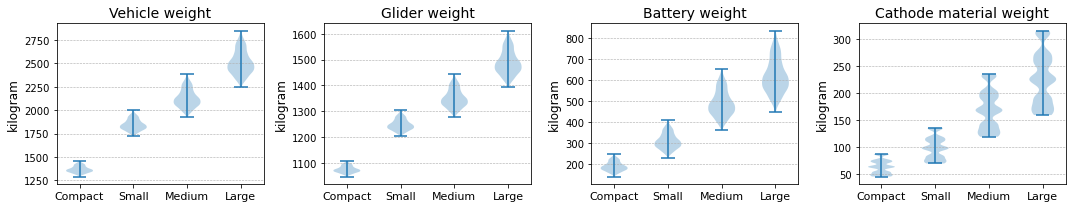

In [9]:
#Battery designs for each segment were calculated iteratively with the battery_design.py module
segments = {
    'Compact': range(0, int(len(D)/4)),
    'Small': range(int(len(D)/4),int(len(D)/4)*2 ),
    'Medium': range(int(len(D)/4)*2,int(len(D)/4)*3 ),
    'Large': range(int(len(D)/4)*3,int(len(D)/4)*4 )
}



fig, ax = plt.subplots(1, 4, figsize=(15, 3))
vehicle_weight = {}
glider_weight = {}
battery_weight = {}
cam_weight = {}

for k, v in segments.items():
    vehicle_weight[k] = [bat_design_param_dct[x]["vehicle_weight"] for x in v]
    glider_weight[k] = [bat_design_param_dct[x]["glider_weight"] for x in v]
    battery_weight[k] = [bat_design_param_dct[x]["battery_system_weight"] for x in v]
    cam_weight[k] = [
        bat_design_param_dct[x]["positive_am_per_cell"]
        * bat_design_param_dct[x]["cells_per_pack"]
        / 1000
        for x in v
    ]

ax[0].violinplot(vehicle_weight.values())
ax[0].set_title("Vehicle weight", fontsize=14)
ax[1].violinplot(glider_weight.values())
ax[1].set_title("Glider weight", fontsize=14)
ax[2].violinplot(battery_weight.values())
ax[2].set_title("Battery weight", fontsize=14)
ax[3].violinplot(cam_weight.values())
ax[3].set_title("Cathode material weight", fontsize=14)


for i, x in enumerate(ax.flatten()):
    x.yaxis.grid(True, linestyle="--", lw=0.6)
    x.set_xticks([y + 1 for y in range(len(segments.keys()))])
    x.set_xticklabels(segments.keys(), fontsize=11)
    x.set_ylabel("kilogram", fontsize=12)
fig.tight_layout()

Or energy densities:

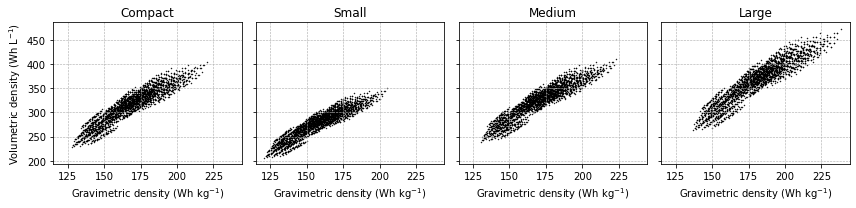

In [10]:
gr_density = {}
vol_density = {}


fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True, sharex=True)


for i, k in enumerate(segments.keys()):

    gr_density[k] = [
        bat_design_param_dct[x]["pack_usable_energy_kWh"]
        / bat_design_param_dct[x]["battery_system_weight"]
        * 1000
        for x in segments[k]
    ]
    vol_density[k] = [
        bat_design_param_dct[x]["pack_usable_energy_kWh"]
        / bat_design_param_dct[x]["system_volume"]
        * 1000
        for x in segments[k]
    ]

    ax[i].scatter(gr_density[k], vol_density[k], c="black", edgecolor="black", s=0.09)
    ax[i].set_title(k)
    ax[i].set_xlabel(r'Gravimetric density (Wh kg$^{-1}$)', fontsize=10)
    ax[i].yaxis.grid(True, linestyle="--", lw=0.6,)
    ax[i].xaxis.grid(True, linestyle="--", lw=0.6,)
ax[0].set_ylabel(r'Volumetric density (Wh L$^{-1}$)', fontsize=10)
fig.tight_layout()

# Battery design

The battery weight and required battery energy are based on a desired vehicle range and segment specific vehicle characteristics, using the following key parameters:


| parameter                | unit        | Compact | Small  | Medium | Large |
|--------------------------|-------------|---------|--------|--------|-------|
| rolling resistance       | N         | 101.86  | 110.59 | 136    | 209.4 |
| rotation resistance      | N/(m/s)  | 3.42    | -1.99  | 3.73   | 2.59  |
| aerodynamic resistance   | N/(m/s)$^{2}$| 0.37    | 0.46   | 0.41   | 0.47  |
| distance        | km          | 200     | 322    | 411    | 460   |
| auxiliary power| W           | 475     | 575    | 715    | 775   |
| motor power    | kW          | 55      | 150    | 150    | 209   |

<br>
<br>
Comparing the modelled results with real values in terms of electricity consumption based on 2020 vehicle registration data from the European Environmental Agency:


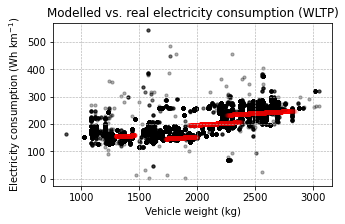

In [414]:
# Import prepared BEV registration data from the European Environmental Agency:
eea_2020 = pd.read_csv(".\data\\result_comparison\EEA_BEV_2020.gzip", compression = 'gzip', low_memory=False)
ener_cons_eea = eea_2020["z (Wh/km)"]
veh_mass = eea_2020["m (kg)"]

# Calculate vehicle electricity consumption from modelled data:
vehicle_weight = [bat_design_param_dct[x]["vehicle_weight"] for x in D]
ener_cons_modelled = [
    bat_design_param_dct[x]["pack_usable_energy_kWh"]
    / bat_design_param_dct[x]["Vehicle_range_km"]
    * 1000
    for x in D
]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(
    veh_mass, ener_cons_eea, color="black", s=10, alpha=0.3, label="EEA WLTP data"
)
ax.scatter(
    vehicle_weight, ener_cons_modelled, color="r", s=15, alpha=0.03, label="Modelled"
)

ax.set_ylabel(r"Electricity consumption (Wh km$^{-1}$)")
ax.set_xlabel("Vehicle weight (kg)")
ax.set_title("Modelled vs. real electricity consumption (WLTP)")
ax.xaxis.grid(
    True,
    linestyle="--",
    lw=0.6,
)
ax.yaxis.grid(
        True,
        linestyle="--",
        lw=0.6,
    )


And comparing the modelled result with real battery weights based on vehicles registered in 2017 and 2020 obtaind from a variety of sources:


In [401]:

# import battery weight data:
battery_wt_real = pd.read_excel(
    ".\data\\result_comparison\pack_weight_2017_2020.xlsx", sheet_name="values"
)
battery_wt_real.head()

,Make,Model,Capacity,battery weight,Segment,vehicle weight,energy density,year,Unnamed: 8
0,Opel,Ampera-E,57.0,407,B,1691,0.140049,2017,NaN
1,Opel,Ampera-E (2020),68.0,430,B,1691,0.158140,2020,NaN
2,Citroen,C-Zero,14.5,132,A,1140,0.109848,2017,NaN
3,Peugeot,E-208,50.0,356,B,1530,0.140449,2020,NaN
4,VW,E-golf,35.8,344,C,1585,0.104070,2017,NaN


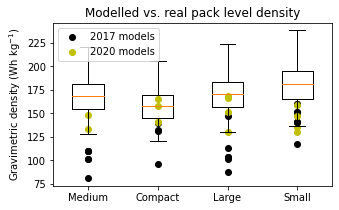

In [402]:
import string

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

density_usable = {}
density_nominal = {}
for i, k in enumerate(segments.keys()):

    density_usable[k] = [
        bat_design_param_dct[x]["pack_usable_energy_kWh"]
        / bat_design_param_dct[x]["battery_system_weight"]
        * 1000
        for x in segments[k]
    ]
ax.boxplot(density_usable.values())
for index, row in battery_wt_real.iterrows():

    x = string.ascii_lowercase.index(row["Segment"].lower())
    y = row["energy density"] * 1000
    if row["year"] == 2017:
        label = "2017 models"
        color = "k"
    else:
        label = "2020 models"
        color = "y"
    ax.scatter(x + 1, y, color=color, label=label)
ax.set_xticklabels({"Compact", "Small", "Medium", "Large"})
handles, labels = ax.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
ax.legend(
    lgd.values(),
    lgd.keys(),
    fontsize=10,
    markerscale=1,
    loc="upper left",
)
ax.set_ylabel(r"Gravimetric density (Wh kg$^{-1}$)")
ax.set_title(r"Modelled vs. real pack level density");



The figure illustrates how battery density has improved over the year.<br> For example, based on the [EPA emissions testing application](https://dis.epa.gov/otaqpub/publist1.jsp), the VW E-golf in 2017 had a density of 103 wh/kg (36 kWh and battery weight 349 kg) as compared to 166 Wh/kg for the VW ID.4 (82 kWh and battery weight of 493). 

# Calculate foreground battery production system

Due to the size constraints of Excel, the foreground matrix ($\bf{A}$) is not imported from the database but instead calculated. <br>

The calculation is based on process formula and parameters and established in Brightway



In [11]:
# import the activity formulas, identical to the ones used in Brightway
process_formula = pd.read_excel(
    ".\data\process_formulas.xlsx",
    sheet_name="activity_functions_cut_off",
    index_col=[1, 2],
).T.to_dict()

# Import the default process parameters (e.g. process yields) as used in Brightway:
default_parameters = (
    pd.read_excel(".\data\\bw_default_project_parameters.xlsx", index_col=0)
    .fillna(0)
    .T.to_dict()
)

In [82]:
# Selecting process yield and energy consumption scenarios:

# energy
process_parameters = {
    param: process_yield
    for param, process_yield in zip(
        IndexTable.loc["Process_parameter", "Classification"].Items,
        ParameterDict["4_PY_battery_manufacturing"].Values[
            :, 0  # default scenario is 0
        ], 
    )
}
# energy consumption
process_parameters.update(
    {
        param: energy_consumption
        for param, energy_consumption in zip(
            IndexTable.loc["Process_parameter", "Classification"].Items,
            ParameterDict["4_PAR_energy_consumption"].Values[:, 1],  # default scenario is 1
        )
        if energy_consumption > 0
    }
)
process_parameters

{'py_am_mixing': 0.99,
 'py_cell_aging': 0.95,
 'py_electrode_stacking': 0.99,
 'py_electrolyte_filling': 0.94,
 'py_foil_coating': 0.99,
 'py_foil_slitting': 0.92,
 'py_nmp_recovery': 0.995,
 'py_separator_stacking': 0.98,
 'py_slurry_coating': 0.95,
 'py_slurry_slitting': 0.99,
 'battery_manufacturing_capacity': 0.0,
 'electricity_consumption_assembly': 0.115,
 'electricity_consumption_mixing': 0.014989104034554055,
 'electricity_consumption_coating_drying': 0.10590494894554918,
 'electricity_consumption_calendering': 0.06752443570376325,
 'electricity_consumption_slitting': 0.02030769591234337,
 'electricity_consumption_final_drying': 0.007182882670973216,
 'electricity_consumption_stacking': 0.027745903390636758,
 'electricity_consumption_cell_assembly': 0.41652482447233097,
 'electricity_consumption_formation': 9.541107320499409,
 'electricity_consumption_material_handling': 0.20851930225039206,
 'electricity_consumption_dryroom': 0.1747882386510639,
 'heat_consumption_coating_dry

The foreground matrix for each battery design is calculated based on the defined process parameters and battery design parameters as solved with BatPaC. <br>


In [83]:
# Empty np array of size all pack design * materials * processes
A_matrix_nested = np.zeros((len(D), len(g), len(p)))

A_base = df_A_base.copy(deep=True)


# dictionary of the battery design parameters for all designs in non-alphanumeric parameters
param_dict_all = {}

# iterate over all pack designs and solve the process formulas based on specific pack parameters and process formulas:
for design in tqdm(D):
    param_dict_all[design] = bat_lca.parameter_dictionary(
        mc_battery_design_dct[design],
        process_parameters,
        bat_design_param_dct[design],
        default_parameters,
    )
    A_matrix_temp = bat_lca.calculate_modular_A(
        A_base, param_dict_all[design], process_formula, default_parameters
    )

    A_matrix_nested[design] = A_matrix_temp

100%|███████████████████████████████████████████████████████████████████████████| 20736/20736 [01:31<00:00, 226.46it/s]


The result is a multi-dimensional numpy array containing all process input and outputs for all battery designs

In [14]:
A_matrix_nested.shape

(20736, 115, 129)

Using the ODYM index table the material flows for each battery design can be easy obtained. <br> <br>
For example, all electricity input for the production of battery design #30 can be simply obtained as follow:

In [15]:
electr_np = A_matrix_nested [30, g.index('electricity for battery production, medium voltage'), [p.index(process) for process in bp]]
df_electr = pd.DataFrame(electr_np, index=bp, columns=['Electricity input (kWh/pack)']).abs()
df_electr[df_electr>0].dropna().T.round(2).sort_values(by ='Electricity input (kWh/pack)', axis=1)


,mixing anode materials,final electrode drying,cathode slitting,anode slitting,mixing cathode materials,anode coating and drying,cell stacking,cathode calendering,anode calendering,cathode coating and drying,module and pack assembly,electrolyte filling and sealing,cell formation
Electricity input (kWh/pack),0.78,1.07,1.36,1.36,1.45,3.78,4.13,5.03,5.03,11.98,58.66,85.48,368.23


# Calculate satellite accounts
Now all related satellite accounts can be calculated. 

## Carbon footprint layer ($\mathbf{h}$)


The carbon footprint layer refers to all life cycle carbon emissions and is calculated based on the modular LCA approach  (Steubing et al., 2016). The total environmental impact ($h$) can be obtained by  multiplying the pre-calculated process emissions ($\mathbf{h_{base}}$) with the scaling vector ($\mathbf{s}$) :

$$h = \mathbf{h_{base}}\times \mathbf{s}$$

To calculate the impacts of all battery designs, the scaling vector is obtained with the matrix based LCA calculation (Heijungs & Suh, 2002):

$$\mathbf{s} = \mathbf{A}^{-1}\mathbf{f}$$

The carbon footprint for all battery designs is calculated as follow:



In [16]:
# First, the relevant production needs to be selected to asssure the A and h matrices are square
country = "European average"

electricity_choice = (
    f"market group for electricity battery production, medium voltage, {country}"
)
gas_choice = f"market group for heat, district or industrial, natural gas, {country}"

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))

# The imported modular h base contains all ReCiPe impact indictors, in this study we only select GWP
impact_cat = 2  # GWP100
# Empty nested np array where the first element refers to all battery designs and the second to the process emissions
H_nested_square = np.zeros([len(D), len(process_selection)])

# Calculate process emissions for each battery design using the formulas described above:

for design in tqdm(D):
    # specific pack weight as function unit:
    fu = A_matrix_nested[
        design, g.index("battery pack"), p.index("module and pack assembly")
    ]
    # Inverse the A matrix:
    A_inv = np.linalg.pinv(A_matrix_nested[design, :, process_selection].T)
    # Establish final product demand vector for 1 battery based on pack weight
    y = np.zeros(len(g))
    y[g.index("battery pack")] = fu
    #Obtain the scaling vector
    s = A_inv.dot(y)
    #Multiply scaling vector by modular base emission vector
    H_nested_square[design, :] = s * H_base[impact_cat, process_selection]

100%|███████████████████████████████████████████████████████████████████████████| 20736/20736 [00:49<00:00, 415.83it/s]


In [17]:
H_nested_square.shape

(20736, 115)

## Value added layer ($\mathbf{v}$)
The value added layer is calculated in two steps: the factor and material cost. <br>

### Battery production factor cost ($\mathbf{F}$)

First, the value added for battery production ($\mathbf{b}_{bat}$) is calculated based on the primary production factor requirements, including building/land, labour and capital requirement. This is calculated based on the physical factor matrix ($\mathbf{F}$) and a vector of factor cost ($\mathbf{\pi}$) as described by Duchin and Levin (2011):
$$\mathbf{v}_{bat}= \mathbf{F}_{bat}\mathbf{\pi}$$


The battery production process factor requirement is calculated with the battery_cost.py script and the "factors_battery_production" formula. The underlying calculations are based on BatPaC and account for different factory sizes

In [165]:
#First the dataset with the default cost parameters is imported. This dataset contains several sheets with data obtained from BatPaC 

default_cost_wb = pd.ExcelFile( ".\data\\default_batpac_parameters.xlsx")

default_cost_lst = [
    pd.read_excel(default_cost_wb, sheet_name="p_values_process", index_col=0).drop(
        "unit", axis=1
    ),
    pd.read_excel(default_cost_wb, sheet_name="baseline_factors", index_col=0).drop(
        "unit", axis=1
    ),
    pd.read_excel(
        default_cost_wb, sheet_name="default_manufacturing_rates", index_col=0
    )
    .iloc[:, 0]
    .to_dict(),
    pd.read_excel(default_cost_wb, sheet_name="volume_ratio_mapping", index_col=0)
    .iloc[:, 0]
    .to_dict(),
    pd.read_excel(default_cost_wb, sheet_name="process_mapping", index_col=0)
    .iloc[:, 0]
    .to_dict(),
]


The "baseline_factors" for example refer to the factor requirements for all battery production processes of the default factory set-up in BatPaC:

In [79]:
default_cost_lst[1]

,receiving,mixing cathode materials,mixing anode materials,anode coating and drying,cathode coating and drying,solvent recovery,cathode calendering,anode calendering,material handling,anode slitting,...,electrolyte filling and sealing,dry room management,rack loading,formation cycling,charge-retention testing,cell sealing and rack unloading,module assembly,pack assembly,rejected cell and scrap recycling,shipping
land,1600,700.0,700.0,1200,1200,500.0,500.0,500.0,2100.0,250,...,1800.0,200.0,1600.00,350.0,1800.0,600.0,1200,1500,1000.0,2500
labour,24000,21600.0,21600.0,36000,36000,14400.0,28800.0,28800.0,57600.0,21600,...,64800.0,7200.0,21600.00,36000.0,10800.0,28800.0,86400,72000,9600.0,72000
capital,8,7.0,7.0,16,16,15.0,2.5,2.5,4.0,2,...,12.0,7.0,28.75,28.0,4.0,15.0,16,11,2.0,20


In [121]:
# Default BatPaC capacity of 100,000 packs per year is used:
manufacturing_capacity = 100000

# Change the capacity parameter for all battery designs
for x in param_dict_all.keys():
    param_dict_all[x]["battery_manufacturing_capacity"] = manufacturing_capacity

factors = IndexTable.loc["Factors", "Classification"].Items
battery_production_index = [p.index(i) for i in bp]

# Empty numpy array:
F_physical_nested = np.zeros((len(D), len(factors), len(p)))

for design in tqdm(D):
    F_matrix_temp = (
        bat_cost.factors_battery_production(param_dict_all[x], run_multiple=default_cost_lst)
        .reindex(columns=bp)
        .fillna(0)
    )  # Fill cathode binder solvent waste handling with 0
    F_physical_nested[design, :, battery_production_index] = F_matrix_temp.T

100%|███████████████████████████████████████████████████████████████████████████| 20736/20736 [02:49<00:00, 122.36it/s]


The physical factor requirements (land and labour) are multiplied with the factor prices ($\pi$) to obtain the monetary factor requirements. <br>

The price factors are country specific. Capital is multiplied by 1.04 to convert the 2018 dollar value as used in BatPaC V4 to 2020 dollar value

In [98]:
df_pie = pd.DataFrame(
    ParameterDict["3_PR_factor_price"].Values, index=f, columns=r
).round(2)
df_pie.insert(0, "Unit", ["$/m2", "$/hr", r"\$$_{2018}$/\$$_{2020}$"])
df_pie

,Unit,FR,DE,HU,NO,PL,SE,GB,European average
land,$/m2,2380.08,2213.95,1219.94,3683.20,1503.39,3074.60,2291.40,2338.08
labour,$/hr,43.25,42.18,11.73,59.48,12.68,43.25,33.77,35.19
capital,\$$_{2018}$/\$$_{2020}$,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04


Multiplying physical factor matrix by the factor prices:

In [122]:
F_monetary_nested = np.zeros((len(D), len(f), len(p)))
for design in tqdm(D):
    factor_cost = ParameterDict["3_PR_factor_price"].Values[
        :, IndexTable.loc["Regions", "Classification"].Items.index(country)
    ]
    production_capacity = param_dict_all[design]["battery_manufacturing_capacity"]
    # Overhead cost:
    factor_cost_overhead = list(bat_cost.factor_overhead_multiplier(production_capacity).values())
    # Total cost
    F_monetary_nested[design, :, battery_production_index] = (
        F_physical_nested[design, :, battery_production_index]
        * (factor_cost * factor_cost_overhead)
        / production_capacity
    )

100%|█████████████████████████████████████████████████████████████████████████| 20736/20736 [00:01<00:00, 20054.61it/s]


The resulting matrix represents the value added in terms of land, labour and capital requiement for each battery production process. <br>

For battery design 30 for exampel, the value added for each process and 1 produced battery is:


In [133]:
pd.DataFrame(F_monetary_nested[30,:, battery_production_index].T, f, bp)/100000

,anode coating and drying,cell formation,material handling,final electrode drying,mixing cathode materials,cathode calendering,jelly roll enclosing,cell stacking,cathode slitting,cathode binder solvent waste recovery,...,cathode binder solvent waste handling,waste anode current collector Cu handling,waste anode slurry handling,waste cathode current collector Al handling,waste cathode slurry handling,separator scrap handling,anode electrode scrap handling,cathode electrode scrap handling,electrolyte scrap handling,cell scrap handling
land,4.195125,10.999558,25.663349,1.896875,3.066594,1.580729,1.444521,4.376057,0.790365,1.207913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
labour,0.000304,0.000704,0.002068,0.000243,0.000239,0.000243,0.000194,0.000489,0.000182,0.000097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capital,0.000785,0.003691,0.002550,0.000229,0.000587,0.000143,0.000167,0.000369,0.000115,0.000625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Battery material cost ($\mathbf{C}$)
The second step of the value added layer are the value added calculation outside the battery factory. This refers to the material cost ($\mathbf{C}$) and is based on the computational structure of life cycle cost as proposed by Heijungs et al. (2012) and Moreau and Weidema (2015) to obain the monetary equivalant of the technology matrix: 

$$\mathbf{C} = \mathbf{A}\mathbf{\alpha}$$

<br>

The general material cost can obtained from the technology matrix ($\mathbf{A}$) and the material cost vector ($\mathbf{\alpha}$). 



The material cost vector consist the mass prices ($\mathbf{\alpha_{mass}}$) obtained from a variety of sources:

In [141]:
df_pr_material_mass = pd.Series(ParameterDict["3_PR_material_price_mass"].Values, g)
pd.DataFrame(df_pr_material_mass [df_pr_material_mass>0], columns=['$/kg']).head(10)

,$/kg
anode active material (natural graphite),9.10020
anode active material (SiO),60.00000
anode active material (synthetic graphite),12.15972
anode binder (CMC),5.00000
anode binder additive (SBR),5.00000
anode carbon black,3.60000
anode current collector Cu (10um),15.43505
anode current collector Cu (11um),15.43505
anode current collector Cu (12um),15.43505
anode current collector Cu (13um),15.43505


And unit prices ($\mathbf{\alpha_{unit}}$) obtained from BatPaC. <br>

The cell container for example, is calculated based on a mass price and the total cells per pack:

In [160]:
df_pr_unit = pd.DataFrame(ParameterDict["3_PR_material_price_unit"].Values, g, P)
df_pr_unit = df_pr_unit[(df_pr_unit != 0).any(axis=1)]
df_pr_unit.loc["cell container"].sort_values()

electrode_pair                    0.000
cell_thickness                    0.000
module_length                     0.000
module_width                      0.000
module_height                     0.000
                                  ...  
current_capacity_pack_terminal    0.000
cost_pack_heating_thermal         0.000
sep_coat_thickness                0.000
cell_thickness_target             0.000
cells_per_pack                    0.208
Name: cell container, Length: 64, dtype: float64

In [166]:
# Default cost parameters from BatPaC:
manuf_rate_base = default_cost_lst[2]
p_values = pd.read_excel(default_cost_wb, sheet_name="p_values_materials", index_col=0).iloc[:, 0].to_dict()
p_values = pd.read_excel(default_cost_wb, sheet_name="material_type_linkage", index_col=0).iloc[:, 0].to_dict()

In [167]:
# Restructure unit prices to dictionary:
dict_pr_unit = {}
for k, v in df_pr_unit.T.to_dict().items():
    dict_pr_unit[k] = {}
    for k2, v2 in v.items():
        if v2 != 0:
            dict_pr_unit[k][k2] = v2

In [169]:
# Empty C matrix
C_matrix_nested = np.zeros((len(D), len(g), len(p)))

In [172]:
unit_material_to_process_mapping = bat_cost.material_to_process_mapping(df_pr_unit.index, df_A_base)
unit_material_to_process_mapping

{'battery jacket': 'module and pack assembly',
 'battery management system': 'module and pack assembly',
 'cell container': 'jelly roll enclosing',
 'cell terminal anode': 'terminal welding',
 'cell terminal cathode': 'terminal welding',
 'gas release': 'module and pack assembly',
 'module container': 'module and pack assembly',
 'module electronics': 'module and pack assembly',
 'module interconnects': 'module and pack assembly',
 'module terminal': 'module and pack assembly',
 'module thermal conductor': 'module and pack assembly',
 'pack heater': 'module and pack assembly',
 'pack terminals': 'module and pack assembly'}

In [174]:
for design in tqdm(D):

    A_matrix_temp = pd.DataFrame(A_matrix_nested[design, :, :], columns=p, index=g)
    C_matrix = bat_cost.material_cost_matrix(
        A_matrix_temp,
        df_pr_material_mass,
        dict_pr_unit,
        material_category,
        manuf_rate_base,
        p_values,
        param_dict_all[design],
        bp,  # internal processes
        unit_material_to_process_mapping=unit_material_to_process_mapping,
        overhead_multiplier=None,
    )
    C_matrix_nested[design, :, :] = C_matrix.values

100%|███████████████████████████████████████████████████████████████████████████| 20736/20736 [02:55<00:00, 118.29it/s]


In [175]:
# Multiply all materials by overhead multiplier:1.0516 based on BatPaC but exclude energy
overhead_multiplier_material = 1.0516

C_matrix_nested[
    :,
    [
        g.index("heat, district or industrial, natural gas for battery production"),
        g.index("electricity for battery production, medium voltage"),
    ],
] * overhead_multiplier_material



array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:

# Multiply by P values to include caling impact:
cathode_am = list(material_category.set_index("material category").loc["cathode active material", "material choices"])
anode_am = list(material_category.set_index("material category").loc["anode active material", "material choices"])
# get process rates:
for k, v in param_dict_all.items():
    process_rate = bat_cost.modelled_process_rates(v)

    C_matrix_nested[k, g.index("cell terminal anode"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell terminal anode"])

    C_matrix_nested[k, g.index("cell terminal cathode"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell terminal cathode"])

    C_matrix_nested[k, [g.index(cathode) for cathode in cathode_am], :] *= (
        manuf_rate_base["baseline_positive_active_material"] / process_rate["positive_active_material"]
    ) ** (1 - p_values["positive active material"])

    C_matrix_nested[k, [g.index(anode) for anode in anode_am], :] *= (
        manuf_rate_base["baseline_negative_active_material"] / process_rate["negative_active_material"]
    ) ** (1 - p_values["negative active material"])

    C_matrix_nested[k, g.index("cell container"), :] *= (
        manuf_rate_base["baseline_total_cell"] / process_rate["total_cell"]
    ) ** (1 - p_values["cell container"])

    C_matrix_nested[k, g.index("module thermal conductor"), :] * (
        manuf_rate_base["baseline_required_cell"] / process_rate["required_cell"]
    ) ** (1 - p_values["module thermal conductor"])

In [176]:
#Include energy cost for all regions:
for region in r:
    electricity_price = ParameterDict['3_PR_regional_energy_price'].Values[0, r.index(region)]   
    gas_price = ParameterDict['3_PR_regional_energy_price'].Values[1, r.index(region)]   
    C_matrix_nested[:, 
                    g.index('electricity for battery production, medium voltage'),
                    p.index(f'market group for electricity battery production, medium voltage, {region}')] = electricity_price
    C_matrix_nested[:, 
                    g.index('heat, district or industrial, natural gas for battery production'),
                    p.index(f'market group for heat, district or industrial, natural gas, {region}')] = gas_price


### Total value added ($\mathbf{v}$)

In [193]:
#Non scaled added value vector:
# process value added based on factor requirements:
v_nested = np.sum(F_monetary_nested/100000, 1)
# material process value added based on C matrix:
v_nested[:] += np.sum(C_matrix_nested,1)

## Substance flow layer ($\mathbf{E}$)

The substance flow matrix ($\mathbf{E}$) is calculated by multiplying the technology matrix with the elemental content of goods ($\mathbf{\tild}$). <br>




For example, 1kg of NMC333 cathode active material contains the following elements:


In [224]:
pd.DataFrame(ParameterDict['3_MC_element_goods'].Values, e,g).loc[:,'cathode active material (NMC333)'].to_frame()

,cathode active material (NMC333)
All,0.000000
Li,0.077618
Al,0.000000
Si,0.000000
P,0.000000
Mn,0.185128
Fe,0.000000
Co,0.198572
Ni,0.197831
Cu,0.000000


In [244]:
E_nested = np.zeros((len(D),IndexTable.loc['Elements','IndexSize'], len(p)))

for design in tqdm(D):
    E_nested[design] =ParameterDict['3_MC_element_goods'].Values.dot(A_matrix_nested[design])

100%|█████████████████████████████████████████████████████████████████████████| 20736/20736 [00:00<00:00, 25323.00it/s]


For example, the total substances for one battery pack (design #30) are:

In [241]:
pd.DataFrame(np.sum(E_matrix_nested[30, :,battery_production_index],0), e).abs()

,0
All,0.000000
Li,5.631963
Al,37.983766
Si,0.000000
P,0.000000
Mn,11.889195
Fe,1.511499
Co,8.501763
Ni,21.175059
Cu,44.335514


# Calculate impact indicators

In [403]:
# First, the relevant production needs to be selected to asssure the A and h matrices are square
country = "European average"

electricity_choice = (
    f"market group for electricity battery production, medium voltage, {country}"
)
gas_choice = f"market group for heat, district or industrial, natural gas, {country}"

process_selection = []

for x in p:
    if x == electricity_choice:
        process_selection.append(p.index(x))
    elif x == gas_choice:
        process_selection.append(p.index(x))
    elif x in p_electricity or x in p_gas:
        continue
    else:
        process_selection.append(p.index(x))


In [ ]:

# Empty nested np array where the first element refers to all battery designs and the second to the process impacts
h_nested_scaled = np.zeros([len(D), len(process_selection)])
v_nested_scaled = np.zeros((len(D), len(process_selection)))
E_nested_scaled = np.zeros((len(D), len(e), len(process_selection)))


# The imported modular h base contains all ReCiPe impact indictors, in this study we only select GWP
impact_cat = 2  # GWP100

p_selection = [p[i] for i in process_selection]

# Calculate process emissions for each battery design using the formulas described above:

for design in tqdm(D):
    # specific pack weight as function unit:
    fu = A_matrix_nested[
        design, g.index("battery pack"), p.index("module and pack assembly")
    ]
    # Inverse the A matrix:
    A_inv = np.linalg.pinv(A_matrix_nested[design, :, process_selection].T)
    # Establish final product demand vector for 1 battery based on pack weight
    y = np.zeros(len(g))
    y[g.index("battery pack")] = fu
    #Obtain the scaling vector
    s = A_inv.dot(y)
    #Multiply scaling vector by modular base emission vector
    h_nested_scaled[design] = s * H_base[impact_cat, process_selection]
    v_nested_scaled[design] = (v_nested[design, process_selection] * s)
    E_nested_scaled [design] = (E_nested[design, :, process_selection].T * s)


$$ c = \sum_{e} EPI_e \times SC_E $$

\begin{equation}
    \mathbf{EPI}_{e} =\frac{ \mathbf{\Omega}_e \times \mathbf{E}_{e, bp}\times -1}{v}
\end{equation}

\begin{equation}
    \mathbf{SDP}_{e, p} =\mathbf{E}_{e,bp}\times-1\odot \mathbf{ESSENZ}_{e}
\end{equation}

In [404]:
df_mineral_price = pd.DataFrame(ParameterDict['3_PR_mineral_price'].Values, e,IndexTable.loc['Sensitivity_analysis', 'Classification'].Items)
df_ESSENZ = pd.DataFrame(ParameterDict['6_CR_ESSENZ_CF_elements'].Values, e)

battery_production_index = [p_selection.index(i) for i in bp]


EPI_scaled = np.zeros((len(D), len(e)))
SC_scaled = np.zeros((len(D), len(e)))

for design in D:
    EPI_scaled[design] = (df_mineral_price['used'].values * E_nested_scaled[design, :,battery_production_index]).sum(axis=0)/v_nested_scaled[design].sum()*-1
    SC_scaled[design]= (E_nested_scaled[design, :,battery_production_index].T * ParameterDict['6_CR_ESSENZ_CF_elements'].Values).sum(axis=1)*-1

c_nested_scaled = EPI_scaled*SC_scaled

In [405]:
p_nested = [bat_design_param_dct[design]["pack_usable_energy_kWh"]/bat_design_param_dct[design]["battery_system_weight"]*1000 for design in D]

# Results for all designs

Overview of the carbon footprint for all 20,736 design options results by cathode chemistry on the pack, energy and kg level:

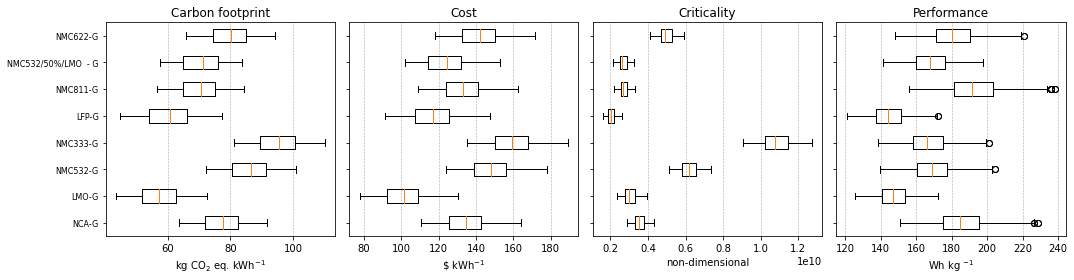

In [396]:
colour = []

cathode_by_design = {design: bat_design_param_dct[design]["electrode_pair"] for design in D}
all_cathodes = set(cathode_by_design.values())

impacts_all = {
    "Carbon footprint": h_nested_scaled,
    "Cost": v_nested_scaled,
    "Criticality":c_nested_scaled,
    "Performance": p_nested
}

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
for idx, impact in enumerate(impacts_all.keys()):
    if impact != 'Performance':
        impacts = {
            design: impacts_all[impact][design].sum() / bat_design_param_dct[design]["pack_energy_kWh"] for design in D
        }
    else:
        impacts = impacts_all[impact]
    y_values = {}
    for cathode in all_cathodes:
        y_values[cathode] = [impacts[x] for x in cathode_by_design.keys() if cathode_by_design[x] == cathode]
    ax[idx].boxplot(y_values.values(), vert=False)
    ax[idx].set_title(impact)
    ax[idx].xaxis.grid(
        True,
        linestyle="--",
        lw=0.6,
    )
    ax[idx].set_yticklabels([])
ax[0].set_xlabel(r"kg CO$_2$ eq. kWh$^{-1}$")
ax[1].set_xlabel(r"\$ kWh$^{-1}$")
ax[2].set_xlabel(r"non-dimensional")
ax[3].set_xlabel(r"Wh kg $^{-1}$")


ax[0].set_yticklabels(all_cathodes, fontsize=8, rotation=0)

fig.tight_layout()

# Calculate optimal design